In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

In [3]:
np.random.seed(42)

In [4]:
from dotenv import load_dotenv
load_dotenv()

alpaca_api_key = "PKMZJNKFRYTWGSPMH3RR"
alpaca_secret_key = "PeIA0dIVFRK5aMaHIiXPcBAblSY721ZIo9e3MMcg"

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
ticker = ["SPY", "AGG"]

timeframe = "1D"

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [34]:
# DAILY ROI
combined_df = df.pct_change()
combined_df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [35]:
# VOLATILITY
avg_daily_return_agg = combined_df.mean()["AGG"]['close']
avg_daily_return_spy = combined_df.mean()["SPY"]['close']

std_dev_daily_return_agg = combined_df.std()["AGG"]['close']
std_dev_daily_return_spy = combined_df.std()["SPY"]['close']
std_dev_daily_return_spy

0.007820053413439366

In [36]:
# LAST DAY CLOSING PRICE
agg_last_price = df["AGG"]['close'][-1]
spy_last_price = df["SPY"]['close'][-1]
spy_last_price

321.92

In [31]:
# MONTE CARLO PARAMETERS
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [37]:
# RUN SIMULATION
for n in range(number_simulations):
    simulated_price_df = pd.DataFrame()
   
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252*30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    #print(simulated_daily_returns)
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
monte_carlo.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499,Simulation 500
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000884,1.000961,1.004668,0.992451,0.999351,1.004790,1.002996,0.994316,0.999875,1.006239,...,1.000651,1.004170,1.004930,1.001494,0.994391,0.996443,1.003212,1.006808,1.002775,0.998818
2,1.008814,1.003590,1.000247,0.998212,0.999673,0.997939,1.001637,0.991857,1.007769,0.996609,...,1.003417,1.000649,1.003570,1.008805,1.000028,0.994248,0.999017,1.005816,1.008249,1.003292
3,1.007954,1.003306,1.001507,1.003030,0.999780,0.993913,1.001154,0.994710,1.003564,0.999738,...,1.001317,0.998091,1.008223,1.008010,0.996362,0.994226,1.004174,1.004979,1.012783,1.004095
4,1.006935,1.000505,0.993661,1.008399,1.002436,0.995384,0.996033,0.997573,1.005568,0.998601,...,1.008668,0.996638,1.008860,1.012277,1.004442,0.991500,1.006446,0.996255,1.012238,0.999074


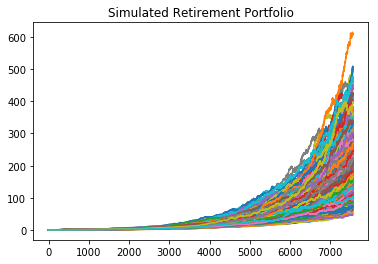

In [38]:
# VISUALIZE THE SIMULATION
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio")

In [40]:
# LAST ROW OF CUMULATIVE RETURNS (AT 30 YEARS)
ending_cumulative_returns = monte_carlo.iloc[-1, :]
ending_cumulative_returns.head()

Simulation 1    223.430088
Simulation 2    184.553165
Simulation 3    256.098311
Simulation 4    269.208006
Simulation 5    240.008303
Name: 7560, dtype: float64

In [41]:
# 90% CONFIDENCE INTERVAL ENDING RETURNS
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     94.322229
0.95    375.627004
Name: 7560, dtype: float64

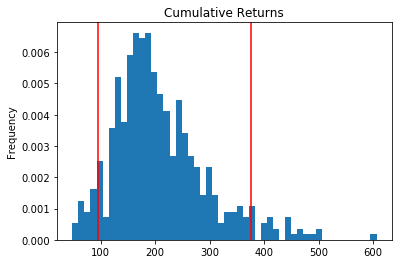

In [44]:
# VISUALIZE ENDING RETURNS
plt.figure();
ending_cumulative_returns.plot(kind="hist", title="Cumulative Returns", density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [45]:
# CUMULATIVE RETURNS AT 30 YEARS FOR 10th, 50th, AND 90th PERCENTILES
cumulative_returns_percentiles = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.90])
print(f"Expected cumulative returns at 30 years for 10th, 50th, 90th percentiles: \n{cumulative_returns_percentiles}")

Expected cumulative returns at 30 years for 10th, 50th, 90th percentiles: 
0.1    118.252534
0.5    190.342960
0.9    313.684237
Name: 7560, dtype: float64


In [46]:
# EXPECTED RETURN AT 10th, 50th, 90th PERCENTILES WITH INITIAL INVESTMENT OF $20,000
initial_investment=20000
cumulative_pnl=initial_investment*cumulative_returns_percentiles
cumulative_pnl.astype(int)

0.1    2365050
0.5    3806859
0.9    6273684
Name: 7560, dtype: int32

In [53]:
# WILL A 4% WITHDRAWL RATE MEET OR EXCEED THAT VALUE OF THE 10th PERCENTILE?
projected_yearly_income = 6085

return_withdrawal = int(cumulative_pnl.iloc[0]*0.4)
return_withdrawal

if projected_yearly_income >= return_withdrawal:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal}, which is less than projected income of ${projected_yearly_income}, so there will be too little funds by retirement")
else:
    print(f"The 4% withdrawal at the 10th percentile is ${return_withdrawal}, which is more than projected income of ${projected_yearly_income}, so there should be sufficient funds at retirement")

The 4% withdrawal at the 10th percentile is $946020, which is more than projected income of $6085, so there should be sufficient funds at retirement


In [56]:
# HOW WOULD A 50% INCREASE IN INITIAL INVESTMENT AFFECT THE 4% WITHDRAWAL?
increased_investment = initial_investment*1.5
increased_investment

# Calculate expected portfolio return with incresed investment amount
increased_cumulative_pnl = increased_investment * cumulative_returns_percentiles

# Calculate the 4% withdrawal for the ending return as retirement income
return_withdrawal_increased = int(increased_cumulative_pnl.iloc[0]*0.04)
return_withdrawal_increased

# Determine if the retirement income meets or exceeds the current projected income
if projected_yearly_income >= return_withdrawal_increased:
    print(f"After an increased investment of 50%, the 4% withdrawal at the 10th percentile is ${return_withdrawal_increased}, which is less than projected income of ${projected_yearly_income}, so there will be too little funds by retirement")
else:
    print(f"After an increased investment of 50%, the 4% withdrawal at the 10th percentile is ${return_withdrawal_increased}, which is more than projected income of ${projected_yearly_income}, so there should be sufficient funds at retirement")

After an increased investment of 50%, the 4% withdrawal at the 10th percentile is $141903, which is more than projected income of $6085, so there should be sufficient funds at retirement
